In [1]:
# Loading library and dataset
import pandas as pd
df = pd.read_csv("/users/tayli/OneDrive/Documents/bitcoin_data.csv")

In [28]:
styled_df = df.head(5).style

# Dataframe background color
styled_df.set_properties(**{"background-color": "lightyellow", "color": "black", "border": "1.5px solid black"})

# Modify the color and background color of the table headers (th)
styled_df.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "lightgrey")]}
])

,Open Time,Open,High,Low,Close,Volume,Target,MA7,MA14,Volatility,Lag1
13,2021-07-09 00:00:00,32875.710000,34100.000000,32261.070000,33815.810000,47153.939899,33502.870000,34059.918571,34153.305714,768.016250,32875.710000
14,2021-07-10 00:00:00,33815.810000,34262.000000,33004.780000,33502.870000,34761.175468,34258.990000,33893.310000,34240.392857,739.814098,33815.810000
15,2021-07-11 00:00:00,33502.870000,34666.000000,33306.470000,34258.990000,31572.647448,33086.630000,33746.521429,34208.867857,470.077445,33502.870000
16,2021-07-12 00:00:00,34259.000000,34678.430000,32658.340000,33086.630000,48181.403762,32729.770000,33660.305714,34108.277857,533.242067,34258.990000
17,2021-07-13 00:00:00,33086.940000,33340.000000,32202.250000,32729.770000,41126.361008,32820.020000,33447.414286,33880.995000,568.836696,33086.630000


In [30]:
df['Open Time'] = pd.to_datetime(df['Open Time'])
df = df.sort_values('Open Time')

df['Target'] = df['Close'].shift(-1)

# Dropping the last row
df = df.dropna()

In [32]:
df['MA7'] = df['Close'].rolling(7).mean()
df['MA14'] = df['Close'].rolling(14).mean()
df['Volatility'] = df['Close'].rolling(7).std()
df['Lag1'] = df['Close'].shift(1)

# Dropping rows with NaN
df = df.dropna()

In [34]:
from sklearn.preprocessing import StandardScaler

features = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA14', 'Volatility', 'Lag1']
X = df[features]
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape

((1145, 8), (287, 8))

In [38]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Function to evaluate and store results
def evaluate(y_true, y_pred, model_name, results=[]):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    results.append({
        "Model": model_name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4),
        "MAPE (%)": round(mape, 2)
    })
    
    return results

# Collect results
results = []
results = evaluate(y_test, y_pred_lr, "Linear Regression", results)
results = evaluate(y_test, y_pred_rf, "Random Forest", results)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Style the DataFrame (bigger + colorful)
styled_results = (
    results_df.style
    .set_table_styles(
        [
            {'selector': 'th', 'props': [
                ('background-color', '#254E58'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('font-size', '25px'),
                ('padding', '12px')
            ]},
            {'selector': 'td', 'props': [
                ('font-size', '16px'),
                ('padding', '10px'),
                ('text-align', 'center')
            ]}
        ]
    )
    .highlight_min(subset=["MAE", "RMSE", "MAPE (%)"], color="lightgreen")  # Best (lower)
    .highlight_max(subset=["R²"], color="lightblue")  # Best (higher)
)

styled_results


,Model,MAE,RMSE,R²,MAPE (%)
0,Linear Regression,1670.390000,2296.180000,0.975700,1.880000
1,Random Forest,20940.000000,24431.270000,-1.748700,21.580000


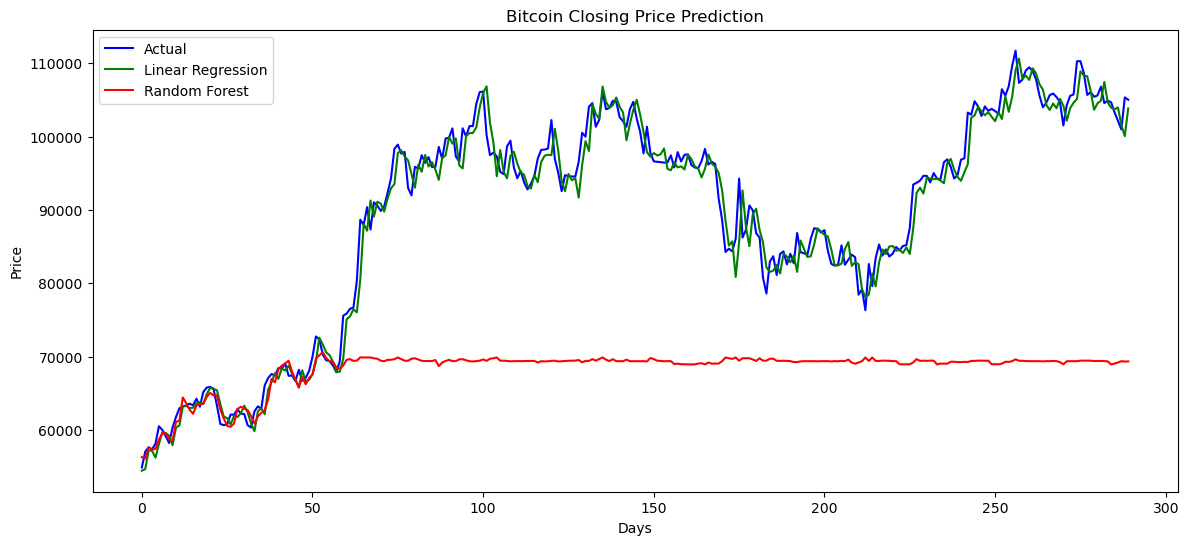

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Actual vs Predicted Prices ---
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_lr, label='Linear Regression', color='green')
plt.plot(y_pred_rf, label='Random Forest', color='red')
plt.title('Bitcoin Closing Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

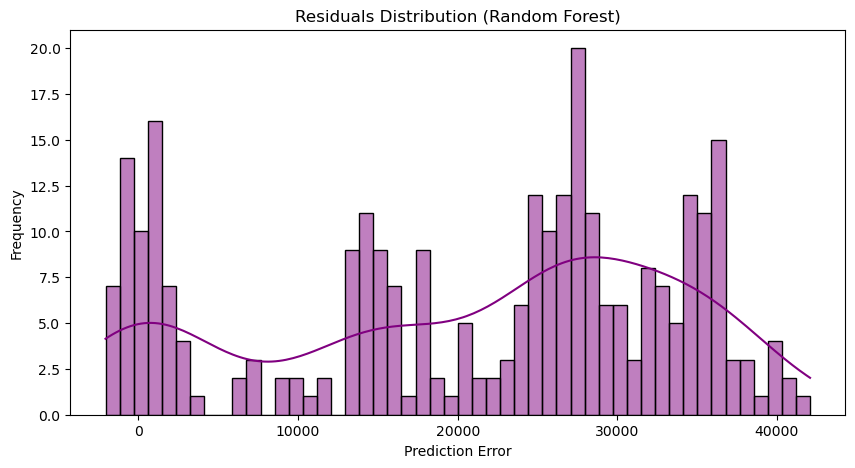

In [11]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

C:\Users\tayli\AppData\Local\Temp\ipykernel_38400\124293401.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


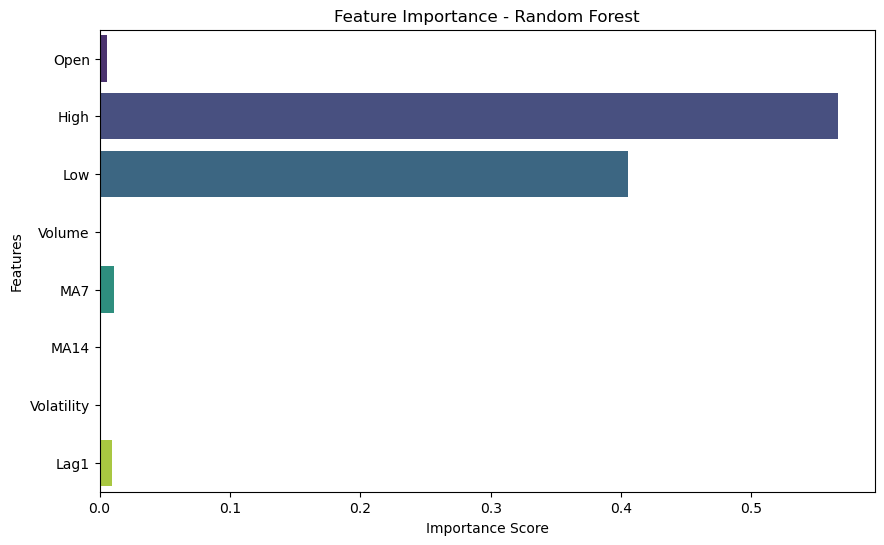

In [12]:
import numpy as np

importances = rf_model.feature_importances_
feature_names = features

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

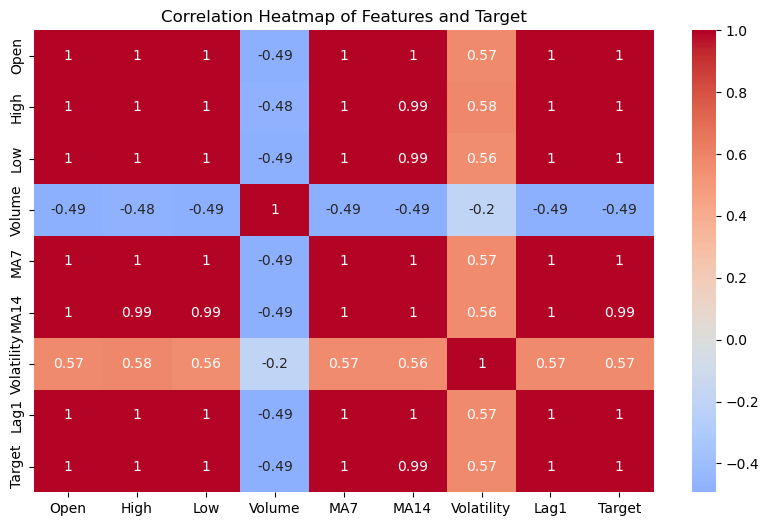

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[features + ['Target']].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features and Target")
plt.show()